# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training, when using batched PCA function
n_pca_batches = 10 # number of batches, when using batched PCA function

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=16

In [4]:
start = time.time()

## Load and Prepare Data

In [50]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 26s, sys: 6.47 s, total: 1min 33s
Wall time: 1min 33s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 

# USE_FIRST_N_CELLS = 1000000
# adata = adata[0:USE_FIRST_N_CELLS]
# adata.shape

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 2min 35s, sys: 37.3 s, total: 3min 12s
Wall time: 3min 12s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1min 2s, sys: 18.9 s, total: 1min 21s
Wall time: 1min 21s


In [10]:
adata.shape

(1291337, 24002)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 9.37 s, sys: 1.72 s, total: 11.1 s
Wall time: 11.1 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 42.1 s, sys: 2.89 ms, total: 42.1 s
Wall time: 42.1 s


### Select Most Variable Genes

In [53]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 30.1 s, sys: 44.2 ms, total: 30.1 s
Wall time: 30 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 36.5 s, sys: 2.02 s, total: 38.5 s
Wall time: 38.5 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 2min 16s, sys: 3min 13s, total: 5min 30s
Wall time: 9min 34s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1min 1s, sys: 4.39 s, total: 1min 5s
Wall time: 1min 5s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1038.9159166812897


## Cluster & Visualize

### Reduce

For a fair comparison with the single-GPU notebook, we calculate the time taken if we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [18]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 20min 41s, sys: 2min 58s, total: 23min 40s
Wall time: 43.8 s


In [19]:
# To perform PCA on the whole dataset:
# %%time
# sc.tl.pca(adata, n_comps=n_components)

### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 6h 52min 56s, sys: 24.6 s, total: 6h 53min 21s
Wall time: 1h 49min 46s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=sc.settings.n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 30min 35s, sys: 28min 36s, total: 59min 12s
Wall time: 2min 29s


In [ ]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

MemoryError: Unable to allocate 6.07 TiB for an array with shape (1, 1291337, 1291337) and data type float32

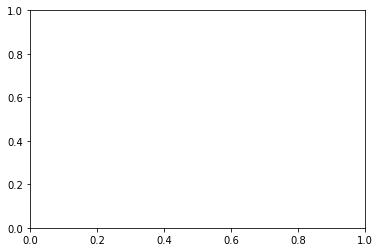

In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 25min 46s, sys: 33min 27s, total: 59min 14s
Wall time: 2min 51s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 7h 46min 8s, sys: 1h 47min 39s, total: 9h 33min 48s
Wall time: 40min 11s


In [26]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 19min 33s, sys: 5.29 s, total: 19min 39s
Wall time: 19min 35s


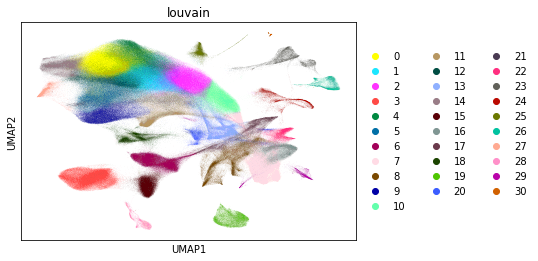

CPU times: user 6.9 s, sys: 38.3 ms, total: 6.94 s
Wall time: 6.93 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [28]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 1h 26min 52s, sys: 2min 11s, total: 1h 29min 4s
Wall time: 1h 28min 49s


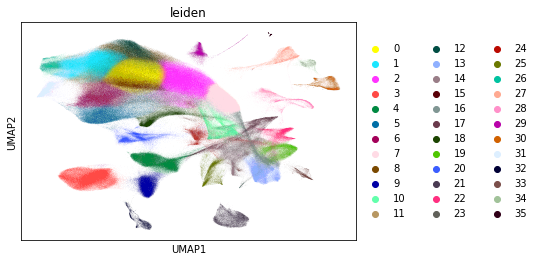

CPU times: user 7.15 s, sys: 30.8 ms, total: 7.18 s
Wall time: 7.18 s


In [29]:
%%time
sc.pl.umap(adata, color=["leiden"])

MemoryError: Unable to allocate 6.07 TiB for an array with shape (1, 1291337, 1291337) and data type float32

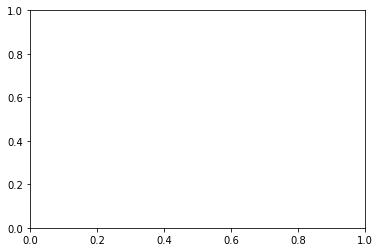

In [30]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [41]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(0, 4000)
CPU times: user 16 ms, sys: 3.37 ms, total: 19.4 ms
Wall time: 13 ms


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

KeyboardInterrupt: 

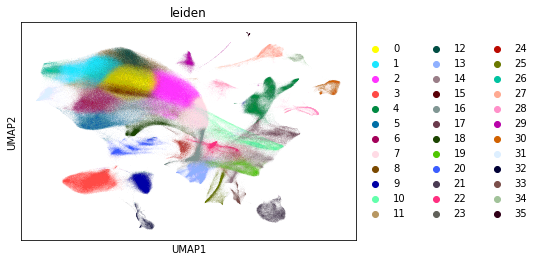

MemoryError: Unable to allocate 6.07 TiB for an array with shape (1, 1291337, 1291337) and data type float32

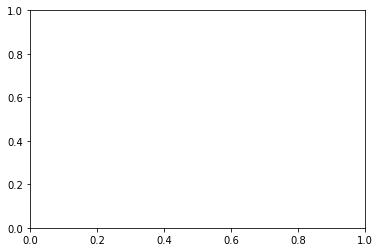

In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 2901.515226125717


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 19928.67300105095
